In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

data_mode
single-session      200
multi-session       800
time-contrastive    250
Name: steps, dtype: int64

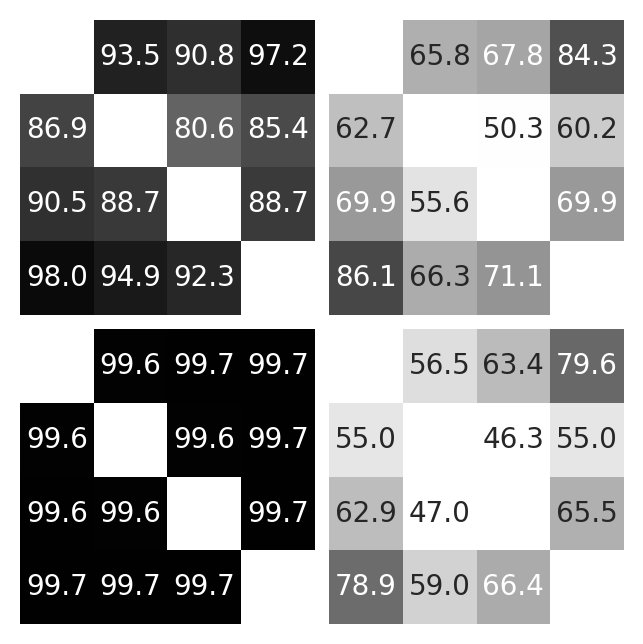

In [15]:
import pandas as pd

def filter_results(results):
  filtered_results = results[
    (results.batch_size == 7200) & 
    (results.learning_rate == 0.003) & 
    (results.num_output == 128) &
    (results.num_hidden_units == 128)
    #(results.steps == 1000)
  ].set_index("data_mode")

  # Filter results to get 60% accuracy for evaluating consistency between single and multi-session
  # training.
  filtered_results = filtered_results[filtered_results["valid_accuracy"] > 60]
  filtered_results = filtered_results.sort_values("valid_accuracy").groupby("data_mode").head(1)#["valid_accuracy"]

  return filtered_results

def show_sweep(df):
  for c in df.columns:
    try:
      values = df[c].unique()
    except TypeError:
      continue
    #if len(values) != len(df):
    if len(values) > 1:
      print(c, values)

def plot_cfm(filtered_results):
  _, axes = plt.subplots(2,2,figsize=(4, 4), dpi = 200)

  for ax_row, data_mode in zip(axes, ["single-session", "multi-session"]):
    for ax, split in zip(ax_row, ["train", "test"]):
      values = filtered_results[f"{split}_consistency_raw"].loc[data_mode]

      cfm = np.zeros((4,4))
      cfm[:] = float("nan")
      cfm[~np.eye(4).astype(bool)] = values
      sns.heatmap(
        cfm * 100, 
        cmap = 'gray_r', 
        vmin = 50, 
        vmax = 100, 
        annot = True, 
        fmt = '.1f', 
        square = True, 
        cbar = False,
        ax = ax
      )
      ax.axis("off")
      #ax.set_title(f"{data_mode} {split}")
  plt.subplots_adjust(wspace=-0.005, hspace=0.05)
  plt.show()

results_ = filter_results(results)
plot_cfm(results_)

data_mode
multi-session     2500
single-session    2500
Name: steps, dtype: int64

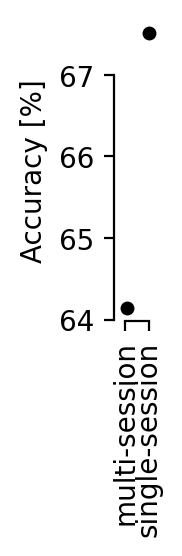

In [30]:
def filter_results_tradeoff(results):
  filtered_results = results[
    (results.batch_size == 7200) & 
    (results.learning_rate == 0.003) & 
    (results.num_output == 128) &
    (results.num_hidden_units == 128) &
    (results.steps == 2500)
  ].sort_values("valid_accuracy").groupby("data_mode").tail(1).set_index("data_mode") #.drop("time-contrastive")

  #baseline = results[
    #(results.batch_size == 512) & 
    #(results.learning_rate == 0.0003) & 
    #(results.steps == 50)
  #].sort_values("valid_accuracy").head(1).set_index("data_mode")

  #baseline = baseline.rename({'multi-session' : 'baseline'})
  #display(filtered_results.steps)

  #filtered_results = pd.concat([filtered_results]).drop("time-contrastive").sort_values("valid_accuracy", ascending = True)
  return filter_results

def plot_tradeoff():
  metric = "test_accuracy"
  plt.figure(figsize = (.3,2), dpi = 200)
  sns.stripplot(
    data = filtered_results.reset_index(),
    y = metric,
    x = "data_mode",
    dodge = False,
    color = "black"
  )
  sns.despine(trim = True)
  plt.ylabel("Accuracy [%]")
  plt.xlabel("")
  #plt.gca().set_xticklabels(["single", "multi"])
  plt.xticks(rotation=90)
  plt.show()

results_ = filter_results_tradeoff(results)
plot_tradeoff(results_)

In [7]:
def _select(values):
  index, values = values[0], values[1:]
  return values[index]

def hyperparameter_pivot(data, select_with, metric, index = [], columns = [], select_func = np.argmin):
  
  idx = data.pivot_table(
    select_with,
    index = index,
    columns = columns,
    aggfunc = lambda v : (select_func(v),)
  )

  agg = data.pivot_table(
    metric,
    index = index,
    columns = columns,
    aggfunc = tuple
  )
  
  if len(agg.columns) == 1:
    idx.columns = [metric]
    agg.columns = [metric]
  
  return (idx + agg).applymap(_select)


from IPython.display import display, HTML

KEYS = 'train_consistency','valid_consistency','test_consistency','valid_accuracy','test_accuracy'

def show_results(
    select_by = "valid_accuracy",
    func = np.argmax,
    keys = KEYS
  ):

  frames = (hyperparameter_pivot(
      results,
      select_by,
      key,
      index = ['data_mode'],
      columns = ['batch_size'],
      select_func=func,
    ) * (100 if "consistency" in key else 1)
    for key in keys)

  display(HTML("<style>.container { width:100% !important; }</style>"))

  titles = [
    "Consistency (R², train)",
    "Consistency (R², valid)",
    "Consistency (R², test)",
    "Accuracy (valid)",
    "Accuracy (test)",
  ]

  #summary = pd.concat(frames, axis = 1)
  #summary.columns = titles
  #return HTML(summary.style.format(precision = 2)._repr_html_())

  return HTML(("\xa0" * 3).join(
    frame.style.set_table_attributes("style='display:inline'").set_caption(title).format(precision = 2)._repr_html_()
    for frame, title in zip(frames, titles))
  )

select_metrics = 'train_consistency','valid_consistency','valid_accuracy'
for key in select_metrics:
  display(show_results(key))
  print('selected by best', key)

,train_consistency
data_mode,
multi-session,99.88
single-session,98.56
time-contrastive,95.81
,valid_consistency
data_mode,
multi-session,53.69
single-session,56.29
time-contrastive,58.34
,test_consistency


selected by best train_consistency


,train_consistency
data_mode,
multi-session,93.14
single-session,82.59
time-contrastive,82.34
,valid_consistency
data_mode,
multi-session,72.34
single-session,70.75
time-contrastive,70.52
,test_consistency


selected by best valid_consistency


,train_consistency
data_mode,
multi-session,99.88
single-session,98.54
time-contrastive,95.81
,valid_consistency
data_mode,
multi-session,53.75
single-session,56.31
time-contrastive,58.34
,test_consistency


selected by best valid_accuracy
